In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import random
import cv2
import os
import tensorflow as tf
from tqdm import tqdm

In [ ]:
bad_frames = 'dataset/blured_image'
good_frames ='dataset/clear_image'

In [ ]:
clean_frames = []
for file in tqdm(sorted(os.listdir(good_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(good_frames + '/' + file, target_size=(128,128))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        clean_frames.append(image)

clean_frames = np.array(clean_frames)
blurry_frames = []
for file in tqdm(sorted(os.listdir(bad_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(bad_frames + '/' + file, target_size=(128,128))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        blurry_frames.append(image)

blurry_frames = np.array(blurry_frames)

100%|██████████| 17/17 [00:00<00:00, 137.83it/s]


In [ ]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras import backend as K

seed = 21
random.seed = seed
np.random.seed = seed

In [ ]:
x = clean_frames;
y = blurry_frames;
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
print(x_train[0].shape)
print(y_train[0].shape)

(128, 128, 3)
(128, 128, 3)


8


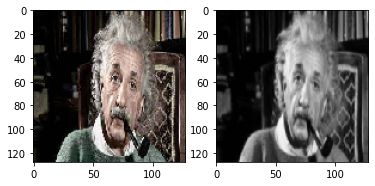

In [ ]:
r = random.randint(0, len(clean_frames)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(clean_frames[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(blurry_frames[r])

In [ ]:
# Network Parameters
input_shape = (128, 128, 3)
batch_size = 32
kernel_size = 3
latent_dim = 256

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

In [ ]:
inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs

In [ ]:
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [ ]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               16777472  
Total params: 17,148,288
Trainable params: 17,148,288
Non-trainable params: 0
_______________________________________________

In [ ]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [ ]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 65536)             16842752  
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 64)      73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 128, 128, 3)       1731

In [ ]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder (Functional)         (None, 256)               17148288  
_________________________________________________________________
decoder (Functional)         (None, 128, 128, 3)       17803395  
Total params: 34,951,683
Trainable params: 34,951,683
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])

In [ ]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

In [ ]:
callbacks = [lr_reducer]
history = autoencoder.fit(blurry_frames,
                      clean_frames,
                      validation_data=(blurry_frames, clean_frames),
                      epochs=100,
                      batch_size=batch_size,
                      callbacks=callbacks)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.0963 - acc: 0.5468 - val_loss: 0.0959 - val_acc: 0.8999
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.0959 - acc: 0.8999 - val_loss: 0.0955 - val_acc: 0.9037
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.0955 - acc: 0.9037 - val_loss: 0.0949 - val_acc: 0.9033
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.0949 - acc: 0.9033 - val_loss: 0.0943 - val_acc: 0.9037
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.0943 - acc: 0.9037 - val_loss: 0.0934 - val_acc: 0.9037
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.0934 - acc: 0.9037 - val_loss: 0.0924 - val_acc: 0.9038
Epoch 7/100
1/1 [==============================] - 3s 3s/step - loss: 0.0924 - acc: 0.9038 - val_loss: 0.0911 - val_acc: 0.9044
Epoch 8/100
1/1 [==============================] - 2s 2s/step - loss: 0.0911 - acc: 0.9044 - val_loss: 0

In [ ]:
autoencoder.save('your_model_name.h5')


       Input                        Ground Truth                  Predicted Value


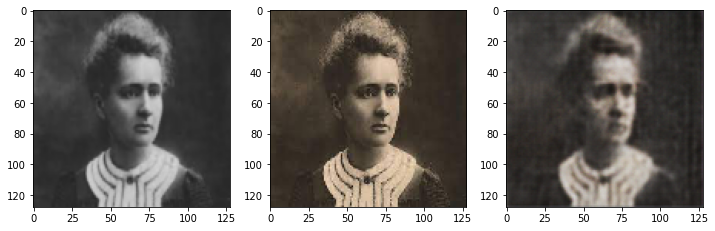

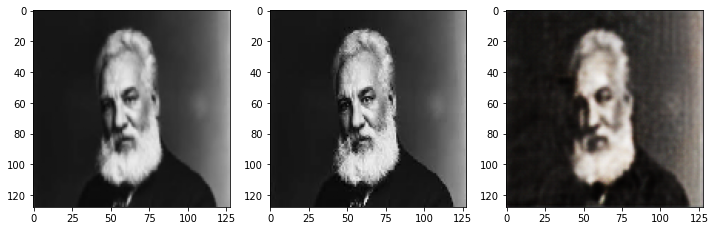

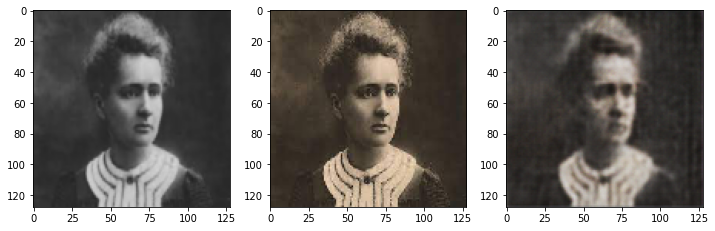

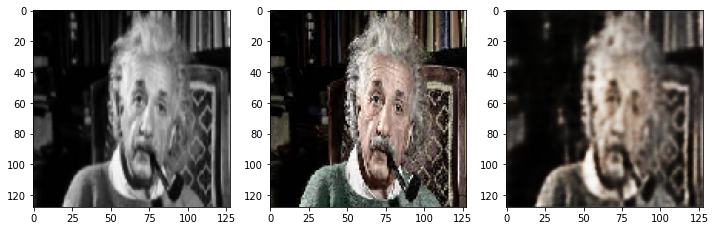

In [ ]:
print("\n       Input                        Ground Truth                  Predicted Value")
for i in range(3,7):

    r = random.randint(0, len(clean_frames)-1)

    x, y = blurry_frames[r],clean_frames[r]
    x_inp=x.reshape(1,128,128,3)
    result = autoencoder.predict(x_inp)
    result = result.reshape(128,128,3)

    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)

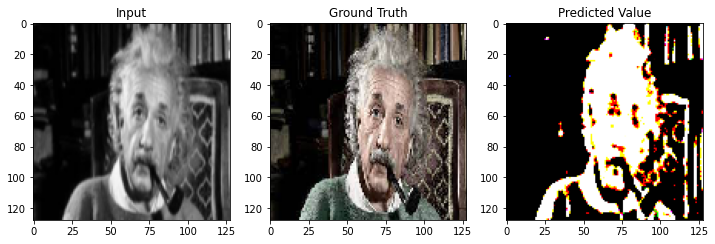

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Assuming you have a custom input image file path
custom_input_image_path = "/kaggle/input/scientist/dataset/blured_image/blurred_eljefojdfowe.jpg"

# Load the custom input image
custom_input_image = cv2.imread(custom_input_image_path)
custom_input_image = cv2.cvtColor(custom_input_image, cv2.COLOR_BGR2RGB)

# Resize the image to match the input shape expected by the model
resized_custom_input_image = cv2.resize(custom_input_image, (128, 128))

# Reshape the image to match the input shape expected by the model
custom_input_image_reshaped = resized_custom_input_image.reshape(1, 128, 128, 3)

# Perform prediction
result = autoencoder.predict(custom_input_image_reshaped)
result = result.reshape(128, 128, 3)

# Plot the results
fig = plt.figure(figsize=(12, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.2)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(resized_custom_input_image)
ax.set_title("Input")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(y)
ax.set_title("Ground Truth")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(result)
ax.set_title("Predicted Value")

plt.show()


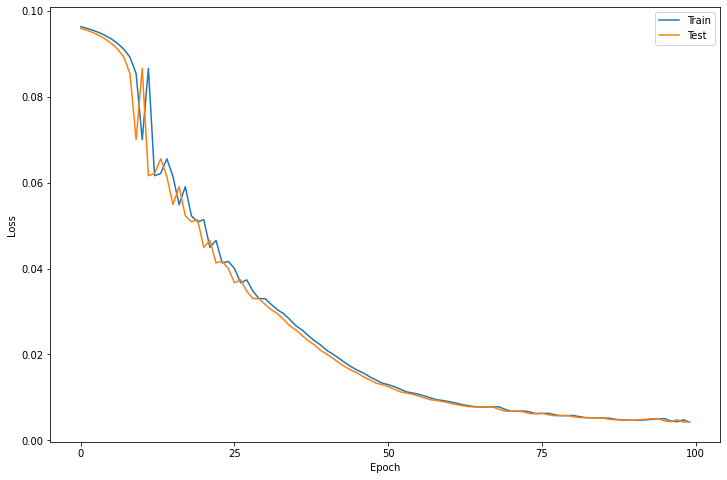

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 101, 25))
plt.show()

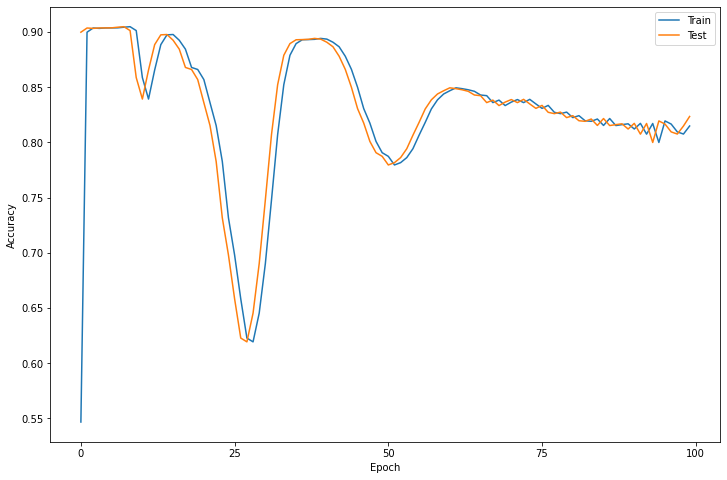

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 101, 25))
plt.show()

Kindly upvote!